In [1]:
from datetime import datetime, timedelta
import pytz
import math
import pylab as plt

import pandas as pd
import numpy as np

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

%matplotlib widget
from plotter import Plot
from filewriter import ExcelWriter as ex

from extractor import WeatherExtractor, Extractor, Period

from inversegreyboxmodel import Learner

n_std_outliers = 3.0 # default for the multiplier of the the standard deviation; further out than this times the std, outliers are removed during preprocessing
up_intv = '5min' # the default upsampling interval that is used before interpolation is done
gap_n_intv = 11 # the default maximum number of consecutive NaNs to fill(one for each upsampling interval), i.e. valid measurement values (11+1)* 5 min = 1 hour apart apart will be bridget by interpolation, but not more
sampling_interval = '15min' # the default interval on which interpolation will be done during preprocessing
moving_horizon_duration_d = 7

#location: center of Assendorp neighbourhood in Zwolle
lat, lon = 52.5065500000, 6.0996100000

#timezone: 
timezone_homes = 'Europe/Amsterdam'

# TODO: get list of pseudonyms, (valid) dates and reference parameters from Excel file?  
# utimately: #min, max dates of the analysis
start = pytz.timezone(timezone_homes).localize(datetime(2021, 10, 21))
end = pytz.timezone(timezone_homes).localize(datetime(2022, 5, 12))
homes = [815925, 817341, 857477, 873985, 879481, 895671, 864296, 845997, 881611, 822479, 831062, 830088, 811308, 809743, 829947, 803422, 886307, 846697, 845966, 839440, 805164, 899510, 897349]
reversedhomes = [803422, 805164, 809743, 811308, 815925, 817341, 822479, 829947, 830088, 831062, 839440, 845966, 845997, 846697, 857477, 864296, 873985, 879481, 881611, 886307, 895671, 897349, 899510]

In [2]:
#check whether the datetime object is properly timezone-aware
start

datetime.datetime(2021, 10, 21, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>)

In [3]:
#check whether the datetime object is properly timezone-aware
end

datetime.datetime(2022, 5, 12, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CEST+2:00:00 DST>)

In [4]:
%%time 
%autoreload 2
# get geospatially interpolated weather from KNMI
# for Twomes, the Weather for all all homes studies can be approached by a single location
# get the dataframe only once for all homes to save time

df_weather = WeatherExtractor.get_interpolated_weather_nl(start, end, lat, lon, timezone_homes, sampling_interval)

Resampling weather data...
CPU times: user 64.4 ms, sys: 11.7 ms, total: 76.2 ms
Wall time: 74.8 ms


In [5]:
df_weather

,outdoor_temp_degC,windspeed_m_per_s,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,effective_outdoor_temp_degC
2021-10-21 00:00:00+02:00,13.221432,3.293213,-1.976263e-323,-5.434722e-323,11.025956
2021-10-21 00:15:00+02:00,13.326340,3.649874,-1.976263e-323,-5.434722e-323,10.893091
2021-10-21 00:30:00+02:00,13.431248,4.006535,-1.976263e-323,-5.434722e-323,10.760225
2021-10-21 00:45:00+02:00,13.536156,4.363196,-1.976263e-323,-5.434722e-323,10.627359
2021-10-21 01:00:00+02:00,13.421445,4.955942,-1.976263e-323,-5.434722e-323,10.117484
...,...,...,...,...,...
2022-05-11 22:00:00+02:00,12.500030,6.209268,-1.976263e-323,-5.434722e-323,8.360518
2022-05-11 22:15:00+02:00,12.204876,6.058109,-1.976263e-323,-5.434722e-323,8.166137
2022-05-11 22:30:00+02:00,11.909722,5.906949,-1.976263e-323,-5.434722e-323,7.971756
2022-05-11 22:45:00+02:00,11.614568,5.755789,-1.976263e-323,-5.434722e-323,7.777376


In [6]:
%%time 
# get interpolated data from the Twomes database and combine with weather data already obtained


# Optionally: oveerride homes and dates for which to get data
homes_to_extract =  [803422, 805164, 817341, 886307, 873985]
# homes_to_extract =  homes

start_extraction = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 3))
end_extraction = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 6))
# start_extraction = start
# end_extraction = end

df_data_homes = Extractor.get_preprocessed_homes_data(homes_to_extract, start_extraction, end_extraction, n_std_outliers, up_intv, gap_n_intv, sampling_interval, timezone_homes, df_weather)

Retrieving data for homes [803422, 805164, 817341, 886307, 873985] from 2022-01-03T00:00:00+01:00 to 2022-01-06T00:00:00+01:00 ...


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.25 s, sys: 37.9 ms, total: 1.28 s
Wall time: 3min 28s


In [7]:
# see what the extracted and interpolated data looks like
df_data_homes

,homepseudonym,outdoor_temp_degC,windspeed_m_per_s,hor_irradiation_J_per_h_per_cm^2,hor_irradiation_W_per_m^2,effective_outdoor_temp_degC,indoor_temp_degC,indoor_temp_degC_CO2,indoor_setpoint_temp_degC,gas_m^3,e_used_normal_kWh,e_used_low_kWh,e_returned_normal_kWh,e_returned_low_kWh,e_used_net_kWh,e_remaining_heat_kWh,timedelta,timedelta_s
2021-10-21 00:00:00+02:00,817341,13.221432,3.293213,-1.976263e-323,-5.434722e-323,11.025956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-10-21 00:15:00+02:00,817341,13.326340,3.649874,-1.976263e-323,-5.434722e-323,10.893091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-10-21 00:30:00+02:00,817341,13.431248,4.006535,-1.976263e-323,-5.434722e-323,10.760225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-10-21 00:45:00+02:00,817341,13.536156,4.363196,-1.976263e-323,-5.434722e-323,10.627359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2021-10-21 01:00:00+02:00,817341,13.421445,4.955942,-1.976263e-323,-5.434722e-323,10.117484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-11 22:00:00+02:00,873985,12.500030,6.209268,-1.976263e-323,-5.434722e-323,8.360518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2022-05-11 22:15:00+02:00,873985,12.204876,6.058109,-1.976263e-323,-5.434722e-323,8.166137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2022-05-11 22:30:00+02:00,873985,11.909722,5.906949,-1.976263e-323,-5.434722e-323,7.971756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0
2022-05-11 22:45:00+02:00,873985,11.614568,5.755789,-1.976263e-323,-5.434722e-323,7.777376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 days 00:15:00,900.0


In [8]:
%%time 
%autoreload 2

filename_prefix = datetime.now().astimezone(pytz.timezone('Europe/Amsterdam')).replace(microsecond=0).isoformat().replace(":","")
ex.write(df_data_homes, str('{0}-data_homes-{1}-{2}.xlsx'.format(filename_prefix, start.isoformat(),end.isoformat())))

CPU times: user 45.9 s, sys: 1.51 s, total: 47.4 s
Wall time: 47.5 s


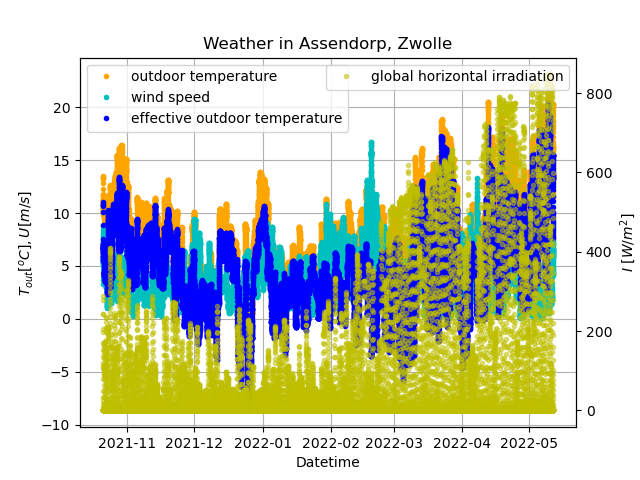

In [9]:
# plot temperature data

Plot.weather_and_other_temperatures('Weather in Assendorp, Zwolle', df_weather)

# N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks

In [10]:
# how to select data from a single home
# df_data_homes[df_data_homes['homepseudonym'] == 817341]

In [14]:
%%time 
%autoreload 2

# homes with most data
# homes_to_analyse = [886307, 873985, 817341]
# start_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2021, 12, 20))
# end_analysis_period = pytz.timezone(timezone_homes).localize(datetime(2022, 1, 18))
# date and times of seemingly valid periods for short set of 3 
# 886307	2021-12-19 18:55	2022-03-17 09:37
# 873985	2021-12-20 12:54	2022-03-17 17:54
# 817341	2022-01-14 20:27	2022-03-17 18:15
    
# homes_to_analyze = [817341]
homes_to_analyze = homes_to_extract
# homes_to_analyze = homes

# use comment/ncomment lines below if you want the default values for full analysis
start_analysis_period = start_extraction
end_analysis_period = end_extraction
# start_analysis_period = start
# end_analysis_period = end

# Use one of the lines below to set the moving horizon duration used for analysis 
moving_horizon_duration_d_analysis = 2
# moving_horizon_duration_d_analysis = moving_horizon_duration_d

# learn the model parameters and write rerults an intermediate results to excel files
df_results = Learner.learn_home_parameter_moving_horizon(df_data_homes, 
                                                         n_std_outliers, up_intv, gap_n_intv, sampling_interval, 
                                                         moving_horizon_duration_d_analysis,
                                                         homes_to_analyze,
                                                         start_analysis_period, end_analysis_period, 
                                                         showdetails=False, A_m2=6.0)

Homes to analyse:  [803422, 805164, 817341, 886307, 873985]
Start of analyses:  2022-01-03 00:00:00+01:00
End of analyses:  2022-01-06 00:00:00+01:00
Moving horizon:  2D
#standard deviations for outlier removal:  3.0
Upsampling_interval:  5min
#upsampling intervals bridged during interpolation (max):  11
Interpolation interval:  15min


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 769 ms, sys: 407 ms, total: 1.18 s
Wall time: 5min 16s


In [15]:
#show the results
df_results

,end_horizon,pseudonym,n_std_outlier_removal,upsampling_interval,n_intv_gap_bridge_upper_bound,interpolation_interval,duration_s,error_K,H_W_per_K,tau_h,A_m^2,A_m^2_fixed,eta_hs,eta_hs_fixed
start_horizon,,,,,,,,,,,,,,
2022-01-03 00:00:00+01:00,2022-01-05,803422,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,TRUE
2022-01-03 00:00:00+01:00,2022-01-05,803422,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,TRUE
2022-01-05 00:00:00+01:00,2022-01-06,803422,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,TRUE
2022-01-05 00:00:00+01:00,2022-01-06,803422,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,TRUE
2022-01-03 00:00:00+01:00,2022-01-05,805164,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,TRUE
2022-01-03 00:00:00+01:00,2022-01-05,805164,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,TRUE
2022-01-05 00:00:00+01:00,2022-01-06,805164,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,TRUE
2022-01-05 00:00:00+01:00,2022-01-06,805164,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,FALSE,NaN,TRUE
2022-01-03 00:00:00+01:00,2022-01-05,817341,3.0,5min,11,15min,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,TRUE


In [ ]:
# plot temperature data of multiple homes from an array 
# %autoreload 2
# for home_id in homes:
#     df_data_one_home = df_data_homes[df_data_homes['homepseudonym'] == home_id]
#     Plot.weather_and_other_temperatures(home_id, df_data_one_home, [('indoor_temp_degC','r'),('indoor_setpoint_temp_degC','g')])

# # N.B. The resulting figure below can be manipulated interactively; hover with mouse for tips & tricks


In [ ]:
#plot a series of weeks for all homes
# plt.ioff()

# for home_id in homes:
#     df_data_one_home = df_data_homes[df_data_homes['homepseudonym'] == home_id]
#     for moving_horizon_start in pd.date_range(start=start, end=end, inclusive='left', freq='7D'):
#         moving_horizon_end = min(end, moving_horizon_start + timedelta(days=7))
#         df_moving_horizon = df_data_one_home[moving_horizon_start:moving_horizon_end]
#         Plot.weather_and_other_temperatures(home_id, df_moving_horizon, ['indoor_temp_degC'])

# plt.ion()  
    